Find ROI from fish scan using NN
====

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Directory path for RDSF fish data

"""
import os

# Where I've mounted it
rdsf_dir = os.path.expanduser("~/zebrafish_rdsf/")

data_dir = os.path.join(rdsf_dir, "DATABASE/uCT/Wahab_clean_dataset/low_res_clean_v3/")

print(data_dir)
assert os.path.isdir(data_dir)

/home/mh19137/zebrafish_rdsf/DATABASE/uCT/Wahab_clean_dataset/low_res_clean_v3/


In [3]:
"""
Read a subset of the images

"""

import numpy as np
from tqdm import tqdm

from dev import image_io

good_imgs = [41, 42, 44, 47, 49, 61, 62]

images = [
    (
        image_io.read_tiffstack(n)
        if not os.path.exists(f"data_cache/{n}.npy")
        else np.load(f"data_cache/{n}.npy")
    )
    for n in tqdm(good_imgs)
]

100%|██████████| 7/7 [00:15<00:00,  2.17s/it]


In [ ]:
"""
Cache them because it took ages to read

"""

if not os.path.exists("data_cache"):
    os.mkdir("data_cache")

for i, img in zip(good_imgs, images):
    if not os.path.exists(f"data_cache/{i}.npy"):
        np.save(f"data_cache/{i}.npy", img)

In [10]:
"""
Downsample the arrays

"""

from multiprocessing import Pool, Manager

from skimage.transform import resize

rescaled_size = (512, 512, 512)

downsampled_images = Manager().dict()


def downsample(i: int) -> None:
    """Downsample an image and add it to the dict"""
    downsampled_images[i] = resize(images[i], rescaled_size, order=0)


with Pool() as pool:
    pool.map(downsample, range(len(images)))

downsampled_images = list(downsampled_images.values())
len(downsampled_images)

7

In [13]:
del images

In [14]:
"""
Find the jaw location in these images from the metadata

"""

from dev import metadata

# Get the mastersheet
mastersheet = metadata.mastersheet()

# Choose the right rows
mastersheet = mastersheet[mastersheet["old_n"].isin(good_imgs)]
assert len(mastersheet) == len(good_imgs)

# Convert to dict
jaw_locs = dict(zip(mastersheet["old_n"], mastersheet["jaw_center"]))

# Convert values in the dict to tuples of [Z X Y]
jaw_locs = {k: image_io.parse_roi(v) for k, v in jaw_locs.items()}
jaw_locs

{41: (1739, 296, 308),
 42: (1694, 330, 470),
 44: (1759, 298, 376),
 47: (1645, 466, 157),
 49: (1561, 399, 482),
 61: (1459, 309, 424),
 62: (1495, 354, 341)}

In [15]:
# Scale the locations to be in the downsampled space

downsampled_jaw_locs = [[i / 10 for i in v] for v in jaw_locs.values()]
downsampled_jaw_locs

[[173.9, 29.6, 30.8],
 [169.4, 33.0, 47.0],
 [175.9, 29.8, 37.6],
 [164.5, 46.6, 15.7],
 [156.1, 39.9, 48.2],
 [145.9, 30.9, 42.4],
 [149.5, 35.4, 34.1]]

[156.1, 39.9, 48.2]


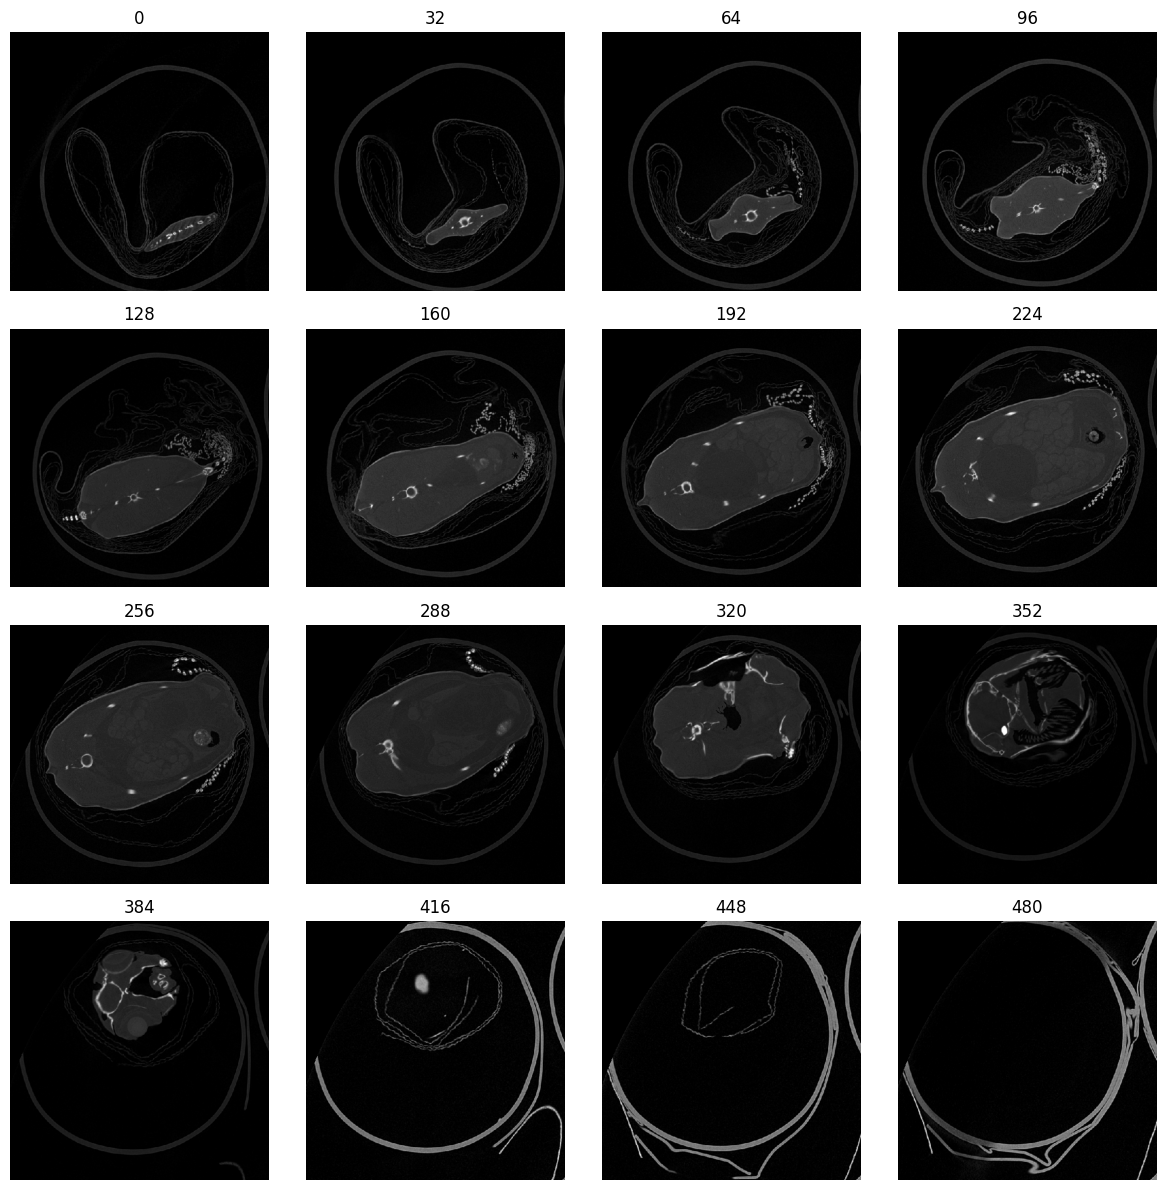

In [17]:
from dev import plot

fig, axes = plot.plot_arr(downsampled_images[4])
print(downsampled_jaw_locs[4])
fig.savefig("downsampled.png")

In [ ]:
"""
Convert them to the right format for the model

"""

import torch

# Normalise, convert to tensor and reshape
tensors = [image_io.img2pytorch(img) for img in tqdm(downsampled_images)]

In [ ]:
# Convert to a dataset
from torch.utils.data import Dataset


class JawLocationDataset(Dataset):
    def __init__(
        self,
        tensors: list[torch.tensor],
        locations: list[tuple[int, int, int]],
    ):
        self.tensors = tensors
        self.locations = torch.tensor(locations, dtype=torch.float32)

        assert len(tensors) == len(locations)

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        """
        Returns a tuple of (image, location)

        """
        return self.tensors[idx], self.locations[idx]

In [ ]:
# Pad the images
from torch.utils.data import DataLoader
from torch.nn.functional import pad


def collate(batch):
    max_depth = 0
    max_height = 0
    max_width = 0
    processed_batch = []

    # Find the max dimensions
    for item in batch:
        data, target = item
        depth, height, width = (
            data.size(1),
            data.size(2),
            data.size(3),
        )  # Assuming data shape is [C, D, H, W]
        if depth > max_depth:
            max_depth = depth
        if height > max_height:
            max_height = height
        if width > max_width:
            max_width = width

    # Pad the images
    for item in batch:
        data, target = item
        depth, height, width = data.size(1), data.size(2), data.size(3)
        # Calculate padding
        pad_left = (max_width - width) // 2
        pad_right = max_width - width - pad_left
        pad_top = (max_height - height) // 2
        pad_bottom = max_height - height - pad_top
        pad_front = (max_depth - depth) // 2
        pad_back = max_depth - depth - pad_front
        # Apply padding
        padded_data = pad(
            data,
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back),
            "constant",
            0,
        )
        processed_batch.append((padded_data, target))

    # Use the default collate function here for the padded batch
    return torch.utils.data.dataloader.default_collate(processed_batch)


dataset = JawLocationDataset(tensors, downsampled_jaw_locs)
dataloader = DataLoader(
    dataset, batch_size=1, shuffle=True, collate_fn=collate
)  # TODO multiple workers

In [ ]:
# Create a model for learning the jaw centre
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        # Run the Module constructor to make
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv3d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm3d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
"""
Define the model architecture

"""


class ResNet3D(nn.Module):
    def __init__(self):
        super(ResNet3D, self).__init__()

        self.conv1 = nn.Conv3d(
            in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm3d(64)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Residual blocks
        self.resblock1 = ResidualBlock(64, 128)
        self.resblock2 = ResidualBlock(128, 256)
        self.resblock3 = ResidualBlock(256, 512)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * 20 * 20 * 20, 512)
        self.fc2 = nn.Linear(256, 3)  # Output layer for 3 coordinates

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.resblock1(x)))
        x = self.pool(F.relu(self.resblock2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = ResNet3D()
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
torch.cuda.is_available()

In [ ]:
"""
Train and dump the model

"""
device = "cuda"

model.to(device)

loss = []
epoch = []
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for image, location in dataloader:
        image, location = image.to(device), location.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, location)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    loss.append(epoch_loss)

In [ ]:
"""
Plot the training loss

"""
import matplotlib.pyplot as plt
plt.plot(range(1, n_epochs + 1), loss)

In [ ]:
# Make a diagram of the architecture
from torchviz import make_dot

dummy_input = torch.randn(1, 1, 160, 160, 160)
dummy_output = model(dummy_input)

graph = make_dot(dummy_output, params=dict(model.named_parameters()))

graph.render("model", format="png")

In [ ]:
# Convert some arrays into numpy arrays
import pathlib
from multiprocessing import Pool

array_dir = pathlib.Path("arrays/")
array_dir.mkdir(exist_ok=True)

# Choose some arrays to save
array_ns = [44, 68, 414]

In [ ]:
def save_array(n: int) -> None:
    if not (array_dir / f"{n}.npy").exists():
        array = tifs2array(n2dir(n), progress=False)
        np.save(array_dir / f"{n}.npy", array)


# Will need to change this as array_ns gets bigger
with Pool(processes=len(array_ns)) as pool:
    pool.map(
        save_array,
        array_ns,
    )

In [ ]:
# Check them
import numpy as np

for n in array_ns:
    arr = np.load(array_dir / f"{n}.npy")
    roi = get_roi(n)
    cropped_array = crop_image(arr, roi)
    plot_slices(cropped_array)

In [ ]:
# Reshape the arrays into a format that the model can use
train_arrs = [np.expand_dims(np.load(array_dir / f"{n}.npy"), axis=0) for n in array_ns]
print(train_arrs[0].shape)

In [ ]:
# Get the jaw centres from the metadata
centres = [get_roi(n) for n in array_ns]
centres

In [ ]:
# Parse the jaw centres to get the right numbers out

In [ ]:
# Train the model on a few jaws, look at training loss etc
